# 4 — Option Strategies and P&L

In this notebook we:

1. Define payoffs and P&L for basic positions:
   - long / short call,
   - long / short put.
2. Build simple option strategies:
   - protective put,
   - covered call,
   - bull call spread,
   - long straddle.
3. Compute payoff and P&L at maturity for a range of underlying prices.
4. Use Black–Scholes prices as initial costs for the options.
5. Plot payoff and P&L diagrams.

The goal is to connect the **static payoff pictures** with the **model prices** we obtained earlier.


In [1]:
import sys
from pathlib import Path

# Adjust this path if needed
project_root = Path(r"C:\Users\Ruben\Desktop\Projects\OptionPricing")
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from option_pricing.black_scholes import black_scholes_call, black_scholes_put

import numpy as np
import math
import matplotlib.pyplot as plt

print("Project root:", project_root)


Project root: C:\Users\Ruben\Desktop\Projects\OptionPricing


## 1. Payoffs for single options

For a given stock price at maturity $S_T$:

- **Call** with strike $K$:
  - long call payoff:
    $$
    \max(S_T - K, 0),
    $$
  - short call payoff:
    $$
    -\max(S_T - K, 0).
    $$
- **Put** with strike $K$:
  - long put payoff:
    $$
    \max(K - S_T, 0),
    $$
  - short put payoff:
    $$
    -\max(K - S_T, 0).
    $$

P\&L at maturity is:

$$
\text{P\&L} = \text{payoff} - \text{initial cost},
$$

where the initial cost is the premium paid (for a long position) or received (for a short position).


In [2]:
def payoff_long_call(ST, K):
    return np.maximum(ST - K, 0.0)

def payoff_short_call(ST, K):
    return -payoff_long_call(ST, K)

def payoff_long_put(ST, K):
    return np.maximum(K - ST, 0.0)

def payoff_short_put(ST, K):
    return -payoff_long_put(ST, K)


In [3]:
S0 = 100.0
K = 100.0
T = 0.5    # 6 months
r = 0.02
sigma = 0.25

ST = np.linspace(40, 160, 241)  # prices at maturity

print("Base parameters:")
print(f"S0 = {S0}, K = {K}, T = {T}, r = {r}, sigma = {sigma}")


Base parameters:
S0 = 100.0, K = 100.0, T = 0.5, r = 0.02, sigma = 0.25


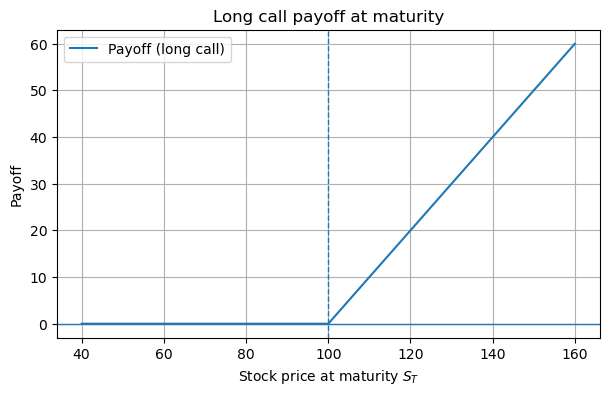

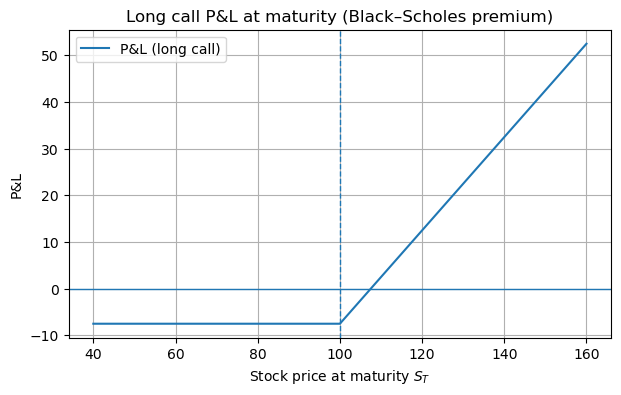

Call premium (Black–Scholes): 7.5168


In [4]:
# Black–Scholes price as initial cost for a long call
call_price = black_scholes_call(S0, K, T, r, sigma)

payoff_call = payoff_long_call(ST, K)
pnl_call = payoff_call - call_price  # P&L at maturity

plt.figure(figsize=(7, 4))
plt.plot(ST, payoff_call, label="Payoff (long call)")
plt.axhline(0, linewidth=1)
plt.axvline(K, linestyle="--", linewidth=1)
plt.xlabel("Stock price at maturity $S_T$")
plt.ylabel("Payoff")
plt.title("Long call payoff at maturity")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(ST, pnl_call, label="P&L (long call)")
plt.axhline(0, linewidth=1)
plt.axvline(K, linestyle="--", linewidth=1)
plt.xlabel("Stock price at maturity $S_T$")
plt.ylabel("P&L")
plt.title("Long call P&L at maturity (Black–Scholes premium)")
plt.grid(True)
plt.legend()
plt.show()

print(f"Call premium (Black–Scholes): {call_price:.4f}")


## 2. Protective put

A **protective put** is:

- long one share of the stock,
- long one put with strike $K$.

At maturity:

- stock payoff: $S_T$,
- put payoff: $\max(K - S_T, 0)$.

Total payoff:

$$
\text{payoff} = S_T + \max(K - S_T, 0).
$$

If $S_T \geq K$, the put expires worthless and payoff is $S_T$.  
If $S_T < K$, the put is in the money and the total payoff is **floored** at $K$:

$$
\text{payoff} =
\begin{cases}
K, & S_T < K, \\
S_T, & S_T \geq K.
\end{cases}
$$

This strategy is like holding the stock with **downside protection**.


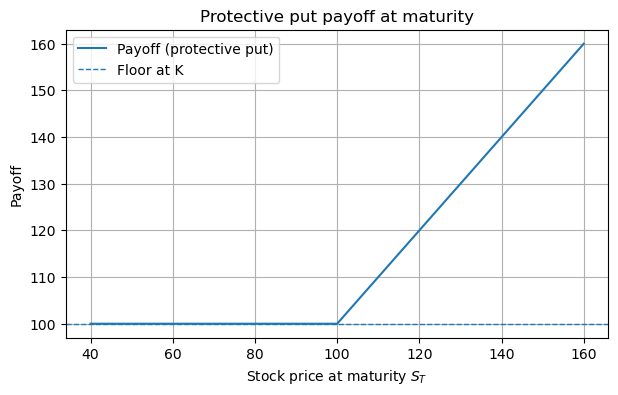

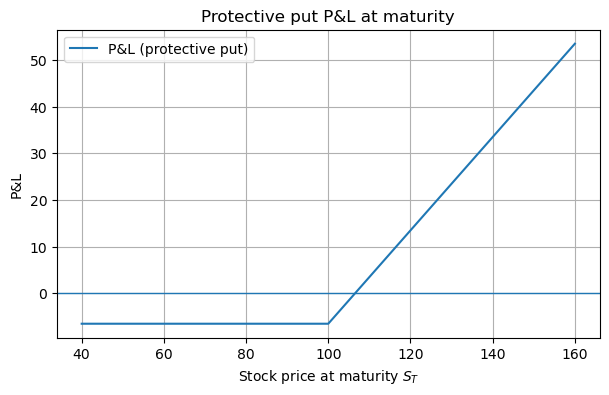

Put premium (Black–Scholes): 6.5218
Initial cost (stock + put):  106.5218


In [5]:
# Black–Scholes price for the put
put_price = black_scholes_put(S0, K, T, r, sigma)

# Assume initial stock price is S0 (we buy the stock at S0)
initial_cost_protective_put = S0 + put_price

payoff_stock = ST  # one share
payoff_put = payoff_long_put(ST, K)
payoff_protective_put = payoff_stock + payoff_put

pnl_protective_put = payoff_protective_put - initial_cost_protective_put

plt.figure(figsize=(7, 4))
plt.plot(ST, payoff_protective_put, label="Payoff (protective put)")
plt.axhline(K, linestyle="--", linewidth=1, label="Floor at K")
plt.xlabel("Stock price at maturity $S_T$")
plt.ylabel("Payoff")
plt.title("Protective put payoff at maturity")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(ST, pnl_protective_put, label="P&L (protective put)")
plt.axhline(0, linewidth=1)
plt.xlabel("Stock price at maturity $S_T$")
plt.ylabel("P&L")
plt.title("Protective put P&L at maturity")
plt.grid(True)
plt.legend()
plt.show()

print(f"Put premium (Black–Scholes): {put_price:.4f}")
print(f"Initial cost (stock + put):  {initial_cost_protective_put:.4f}")


## 3. Covered call

A **covered call** is:

- long one share of the stock,
- short one call with strike $K$.

At maturity:

- stock payoff: $S_T$,
- short call payoff: $-\max(S_T - K, 0)$.

Total payoff:

$$
\text{payoff} = S_T - \max(S_T - K, 0).
$$

This equals:

- $S_T$ if $S_T \leq K$ (call is out-of-the-money),
- $K$ if $S_T > K$ (call is exercised and we effectively sell the stock at $K$).

So the covered call payoff is like:

- owning the stock,
- but with **upside capped at $K$**,
- and receiving the call premium at the start.

It is sometimes used as an income-generating strategy.


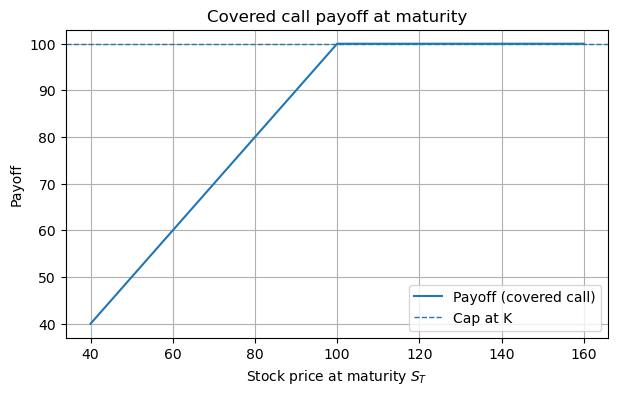

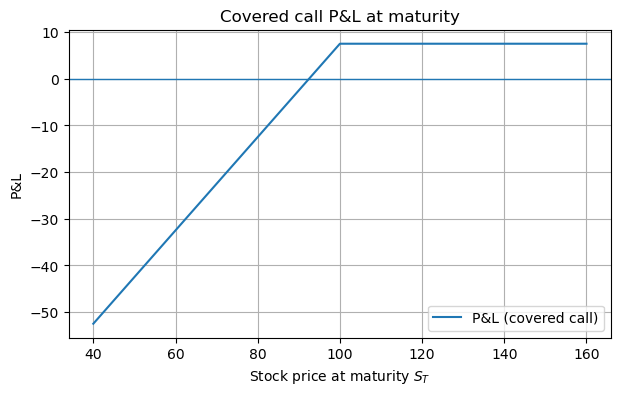

Initial cost (stock - call premium): 92.4832


In [6]:
initial_cost_covered_call = S0 - call_price  # long stock, short call

payoff_covered_call = payoff_stock + payoff_short_call(ST, K)
pnl_covered_call = payoff_covered_call - initial_cost_covered_call

plt.figure(figsize=(7, 4))
plt.plot(ST, payoff_covered_call, label="Payoff (covered call)")
plt.axhline(K, linestyle="--", linewidth=1, label="Cap at K")
plt.xlabel("Stock price at maturity $S_T$")
plt.ylabel("Payoff")
plt.title("Covered call payoff at maturity")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(ST, pnl_covered_call, label="P&L (covered call)")
plt.axhline(0, linewidth=1)
plt.xlabel("Stock price at maturity $S_T$")
plt.ylabel("P&L")
plt.title("Covered call P&L at maturity")
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

print(f"Initial cost (stock - call premium): {initial_cost_covered_call:.4f}")


## 4. Bull call spread

A **bull call spread** is:

- long one call with lower strike $K_1$,
- short one call with higher strike $K_2 > K_1$.

At maturity, the payoff is:

$$
\text{payoff} =
\max(S_T - K_1, 0) - \max(S_T - K_2, 0).
$$

This strategy:

- profits if the stock goes **up**,
- but with **limited upside** (capped at $K_2 - K_1$),
- and has **limited downside** (maximum loss equals the net premium paid).


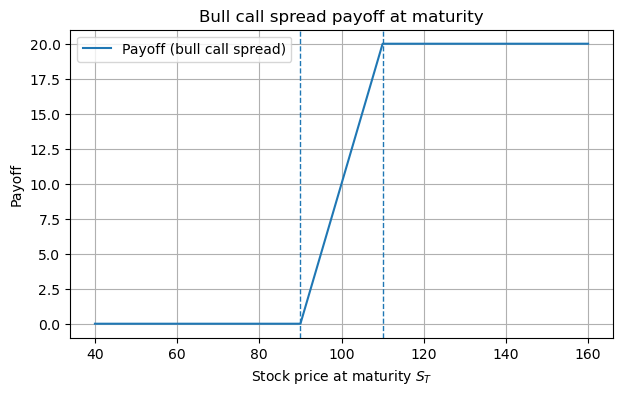

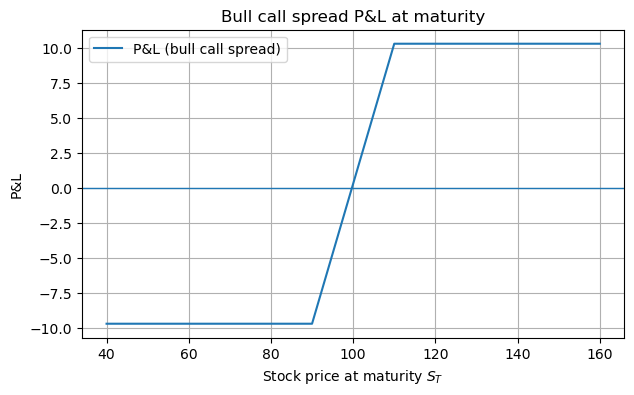

Call(K1=90.0) price: 13.4716
Call(K2=110.0) price: 3.7417
Initial cost (bull spread): 9.7299


In [7]:
K1 = 90.0
K2 = 110.0

# Black–Scholes prices for the two calls
call_K1 = black_scholes_call(S0, K1, T, r, sigma)
call_K2 = black_scholes_call(S0, K2, T, r, sigma)

initial_cost_bull_spread = call_K1 - call_K2  # long K1, short K2

payoff_bull_spread = payoff_long_call(ST, K1) - payoff_long_call(ST, K2)
pnl_bull_spread = payoff_bull_spread - initial_cost_bull_spread

plt.figure(figsize=(7, 4))
plt.plot(ST, payoff_bull_spread, label="Payoff (bull call spread)")
plt.axvline(K1, linestyle="--", linewidth=1)
plt.axvline(K2, linestyle="--", linewidth=1)
plt.xlabel("Stock price at maturity $S_T$")
plt.ylabel("Payoff")
plt.title("Bull call spread payoff at maturity")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(ST, pnl_bull_spread, label="P&L (bull call spread)")
plt.axhline(0, linewidth=1)
plt.xlabel("Stock price at maturity $S_T$")
plt.ylabel("P&L")
plt.title("Bull call spread P&L at maturity")
plt.grid(True)
plt.legend()
plt.show()

print(f"Call(K1={K1}) price: {call_K1:.4f}")
print(f"Call(K2={K2}) price: {call_K2:.4f}")
print(f"Initial cost (bull spread): {initial_cost_bull_spread:.4f}")


## 5. Long straddle

A **long straddle** is:

- long one call with strike $K$,
- long one put with the same strike $K$ and maturity $T$.

At maturity:

$$
\text{payoff} =
\max(S_T - K, 0) + \max(K - S_T, 0) = |S_T - K|.
$$

The straddle profits from **large moves** in either direction and loses if the stock stays close to the strike.

It is a simple way to trade **volatility** rather than direction.


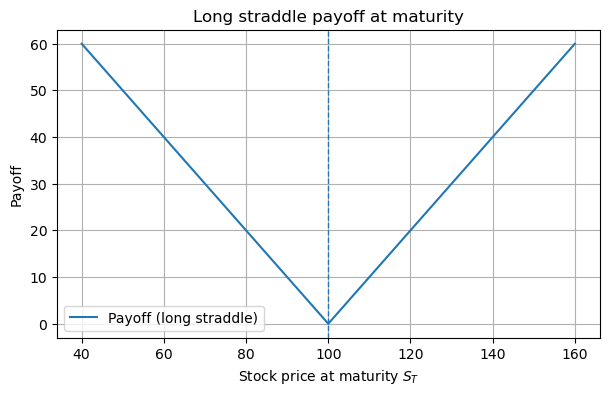

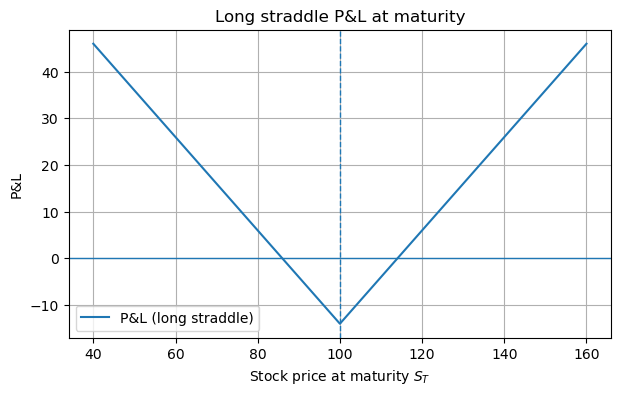

Call ATM price:     7.5168
Put ATM price:      6.5218
Initial cost (straddle): 14.0387


In [8]:
# Use the at-the-money strike K from earlier
call_atm = call_price        # black_scholes_call(S0, K, T, r, sigma)
put_atm = put_price          # black_scholes_put(S0, K, T, r, sigma)

initial_cost_straddle = call_atm + put_atm

payoff_straddle = payoff_long_call(ST, K) + payoff_long_put(ST, K)
pnl_straddle = payoff_straddle - initial_cost_straddle

plt.figure(figsize=(7, 4))
plt.plot(ST, payoff_straddle, label="Payoff (long straddle)")
plt.axvline(K, linestyle="--", linewidth=1)
plt.xlabel("Stock price at maturity $S_T$")
plt.ylabel("Payoff")
plt.title("Long straddle payoff at maturity")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(7, 4))
plt.plot(ST, pnl_straddle, label="P&L (long straddle)")
plt.axhline(0, linewidth=1)
plt.axvline(K, linestyle="--", linewidth=1)
plt.xlabel("Stock price at maturity $S_T$")
plt.ylabel("P&L")
plt.title("Long straddle P&L at maturity")
plt.grid(True)
plt.legend()
plt.show()

print(f"Call ATM price:     {call_atm:.4f}")
print(f"Put ATM price:      {put_atm:.4f}")
print(f"Initial cost (straddle): {initial_cost_straddle:.4f}")


## 6. Interpretation of strategies

- **Protective put**:
  - Downside protection: payoff never falls below $K$.
  - You pay a premium for insurance.

- **Covered call**:
  - Receive income from selling the call.
  - Upside is capped at $K$.
  - You are partially protected on the downside by the premium received, but you still have large downside risk.

- **Bull call spread**:
  - Limited loss (net premium).
  - Limited profit ($K_2 - K_1$).
  - Used for moderately bullish views.

- **Long straddle**:
  - Large loss if the price stays near $K$.
  - Profits if the price moves strongly up or down.
  - Used to express a view that **volatility** will be high.


# Conclusion

In this notebook we:

- Implemented payoff functions for single options (long/short calls and puts).
- Built several classical option strategies:
  - protective put,
  - covered call,
  - bull call spread,
  - long straddle.
- Used Black–Scholes prices as initial premiums.
- Computed and plotted **payoff** and **P&L** profiles at maturity
  for a range of underlying prices.

These diagrams connect the theoretical Black–Scholes prices with the
practical behavior of option strategies.

In the final notebook **5 — Conclusion**, we will summarize the entire project:

- assumptions and limitations of Black–Scholes,
- what we learned from pricing, Greeks, implied volatility and strategies,
- and how this project could be extended (stochastic volatility, jumps, dividends, etc.).
